# Estimation of COVID-19 Pandemic

## Loading Data

We will use data on COVID-19 infected individuals, provided by the [Center for Systems Science and Engineering](https://systems.jhu.edu/) (CSSE) at [Johns Hopkins University](https://jhu.edu/). Dataset is available in [this GitHub Repository](https://github.com/CSSEGISandData/COVID-19).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,3) # make figures larger

We can load the most recent data directly from GitHub using `pd.read_csv`. If for some reason the data is not available, you can always use the copy available locally in the `data` folder - just uncomment the line below that defines `base_url`:

In [ ]:
# base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/" # loading from Internet
base_url = "../../data/COVID/" # loading from disk
infected_dataset_url = base_url + "time_series_covid19_confirmed_global.csv"
recovered_dataset_url = base_url + "time_series_covid19_recovered_global.csv"
deaths_dataset_url = base_url + "time_series_covid19_deaths_global.csv"
countries_dataset_url = base_url + "../UID_ISO_FIPS_LookUp_Table.csv"

Let's now load the data for infected individuals and see how the data looks like:

In [ ]:
infected = pd.read_csv(infected_dataset_url)
infected.head()

We can see that each row of the table defines the number of infected individuals for each country and/or province, and columns correspond to dates. Similar tables can be loaded for other data, such as number of recovered and number of deaths.

In [ ]:
recovered = pd.read_csv(recovered_dataset_url)
deaths = pd.read_csv(deaths_dataset_url)

## Making Sense of the Data

From the table above the role of province column is not clear. Let's see the different values that are present in `Province/State` column:

In [ ]:
infected['Province/State'].value_counts()

From the names we can deduce that countries like Australia and China have more detailed breakdown by provinces. Let's look for information on China to see the example:

In [ ]:
infected[infected['Country/Region']=='China']

## Pre-processing the Data 

We are not interested in breaking countries down to further territories, thus we would first get rid of this breakdown and add information on all territories together, to get info for the whole country. This can be done using `groupby`:

In [ ]:
infected = infected.groupby('Country/Region').sum()
recovered = recovered.groupby('Country/Region').sum()
deaths = deaths.groupby('Country/Region').sum()

infected.head()

You can see that due to using `groupby` all DataFrames are now indexed by Country/Region. We can thus access the data for a specific country by using `.loc`:|

In [ ]:
infected.loc['US'][2:].plot()
recovered.loc['US'][2:].plot()
plt.show()

> **Note** how we use `[2:]` to remove first two elements of a sequence that contain geolocation of a country. We can also drop those two columns altogether:

In [ ]:
infected.drop(columns=['Lat','Long'],inplace=True)
recovered.drop(columns=['Lat','Long'],inplace=True)
deaths.drop(columns=['Lat','Long'],inplace=True)

In [18]:
infected.drop(columns=['Province/State'],inplace=True)
recovered.drop(columns=['Province/State'],inplace=True)
deaths.drop(columns=['Province/State'],inplace=True)

## Investigating the Data

Let's now switch to investigating a specific country. Let's create a frame that contains the data on infections indexed by date:

In [19]:
def mkframe(country):
    df = pd.DataFrame({ 'infected' : infected.loc[country] ,
                        'recovered' : recovered.loc[country],
                        'deaths' : deaths.loc[country]})
    df.index = pd.to_datetime(df.index)
    # The index is throwing an error because the first row in the data is not a date. How can I fix this?
    return df

df = mkframe('US')
df

C:\Users\jmann\AppData\Local\Temp\ipykernel_10516\1833382756.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


,infected,recovered,deaths
2020-01-22,1,0,0
2020-01-23,1,0,0
2020-01-24,2,0,0
2020-01-25,2,0,0
2020-01-26,5,0,0
...,...,...,...
2020-06-11,2023590,540292,113823
2020-06-12,2048986,547386,114669
2020-06-13,2074526,556606,115436
2020-06-14,2094058,561816,115732


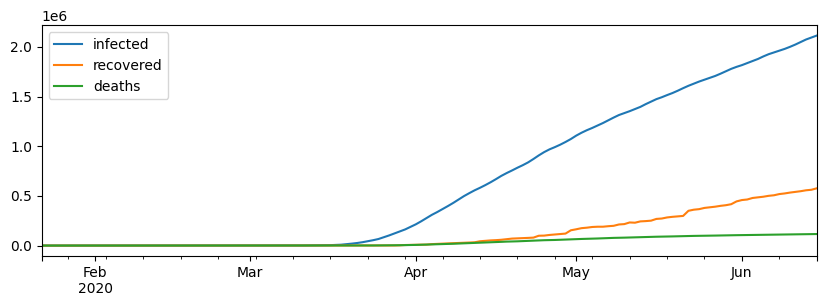

In [20]:
df.plot()
plt.show()

Now let's compute the number of new infected people each day. This will allow us to see the speed at which pandemic progresses. The easiest day to do it is to use `diff`:

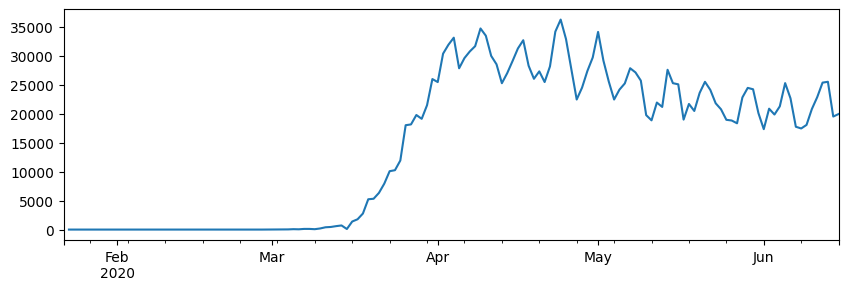

In [21]:
df['ninfected'] = df['infected'].diff()
df['ninfected'].plot()
plt.show()

We can see high fluctuations in data. Let's look closer at one of the months:

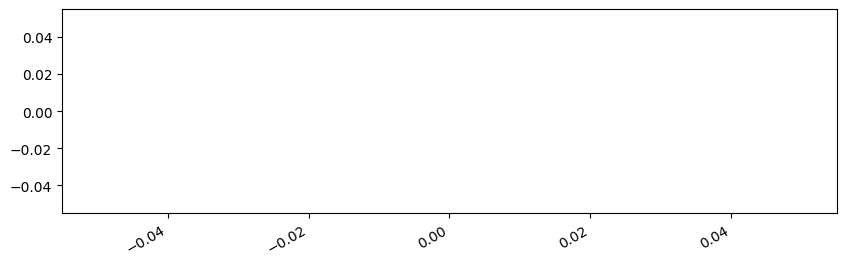

In [22]:
df[(df.index.year==2020) & (df.index.month==7)]['ninfected'].plot()
plt.show()

It clearly looks like there are weekly fluctuations in data. Because we want to be able to see the trends, it makes sense to smooth out the curve by computing running average (i.e. for each day we will compute the average value of the previous several days):

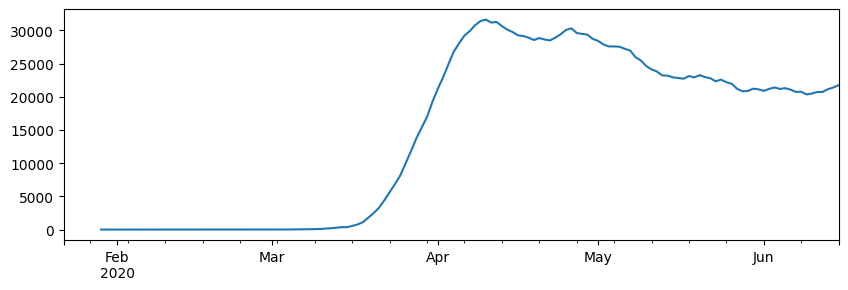

In [23]:
df['ninfav'] = df['ninfected'].rolling(window=7).mean()
df['ninfav'].plot()
plt.show()

In order to be able to compare several countries, we might want to take the country's population into account, and compare the percentage of infected individuals with respect to country's population. In order to get country's population, let's load the dataset of countries:

In [24]:
countries = pd.read_csv(countries_dataset_url)
countries

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
0,4,AF,AFG,4.0,NaN,NaN,NaN,Afghanistan,33.939110,67.709953,Afghanistan,38928341.0
1,8,AL,ALB,8.0,NaN,NaN,NaN,Albania,41.153300,20.168300,Albania,2877800.0
2,12,DZ,DZA,12.0,NaN,NaN,NaN,Algeria,28.033900,1.659600,Algeria,43851043.0
3,20,AD,AND,20.0,NaN,NaN,NaN,Andorra,42.506300,1.521800,Andorra,77265.0
4,24,AO,AGO,24.0,NaN,NaN,NaN,Angola,-11.202700,17.873900,Angola,32866268.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4016,84056037,US,USA,840.0,56037.0,Sweetwater,Wyoming,US,41.659439,-108.882788,"Sweetwater, Wyoming, US",42343.0
4017,84056039,US,USA,840.0,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",23464.0
4018,84056041,US,USA,840.0,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",20226.0
4019,84056043,US,USA,840.0,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,"Washakie, Wyoming, US",7805.0


Because this dataset contains information on both countries and provinces, to get the population of the whole country we need to be a little bit clever: 

In [25]:
countries[(countries['Country_Region']=='US') & countries['Province_State'].isna()]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population
697,840,US,USA,840.0,NaN,NaN,NaN,US,40.0,-100.0,US,329466283.0


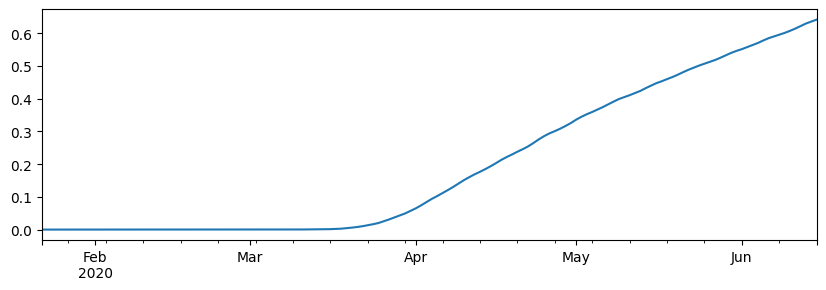

In [26]:
pop = countries[(countries['Country_Region']=='US') & countries['Province_State'].isna()]['Population'].iloc[0]
df['pinfected'] = df['infected']*100 / pop
df['pinfected'].plot(figsize=(10,3))
plt.show()


## Computing $R_t$

To see how infectious is the disease, we look at the **basic reproduction number** $R_0$, which indicated the number of people that an infected person would further infect. When $R_0$ is more than 1, the epidemic is likely to spread.

$R_0$ is a property of the disease itself, and does not take into account some protective measures that people may take to slow down the pandemic. During the pandemic progression, we can estimate the reproduction number $R_t$ at any given time $t$. It has been shown that this number can be roughly estimated by taking a window of 8 days, and computing $$R_t=\frac{I_{t-7}+I_{t-6}+I_{t-5}+I_{t-4}}{I_{t-3}+I_{t-2}+I_{t-1}+I_t}$$
where $I_t$ is the number of newly infected individuals on day $t$.

Let's compute $R_t$ for our pandemic data. To do this, we will take a rolling window of 8 `ninfected` values, and apply the function to compute the ratio above:

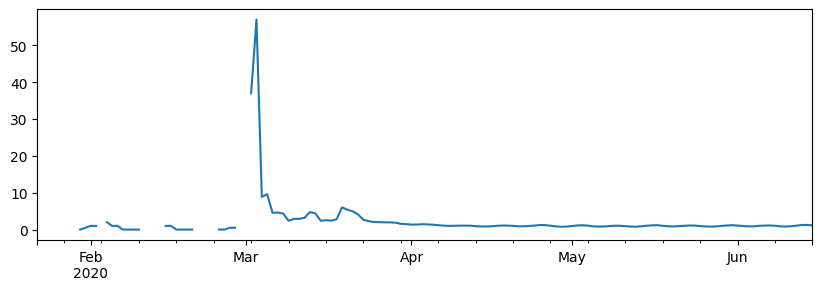

In [27]:
df['Rt'] = df['ninfected'].rolling(8).apply(lambda x: x[4:].sum()/x[:4].sum())
df['Rt'].plot()
plt.show()

You can see that there are some gaps in the graph. Those can be caused by either `NaN`, if  `inf` values being present in the dataset. `inf` may be caused by division by 0, and `NaN` can indicate missing data, or no data available to compute the result (like in the very beginning of our frame, where rolling window of width 8 is not yet available). To make the graph nicer, we need to fill those values using `replace` and `fillna` function.

Let's further look at the beginning of the pandemic. We will also limit the y-axis values to show only values below 6, in order to see better, and draw horizontal line at 1.

C:\Users\jmann\AppData\Local\Temp\ipykernel_10516\1618873019.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ax = df[df.index<"2020-05-01"]['Rt'].replace(np.inf,np.nan).fillna(method='pad').plot(figsize=(10,3))


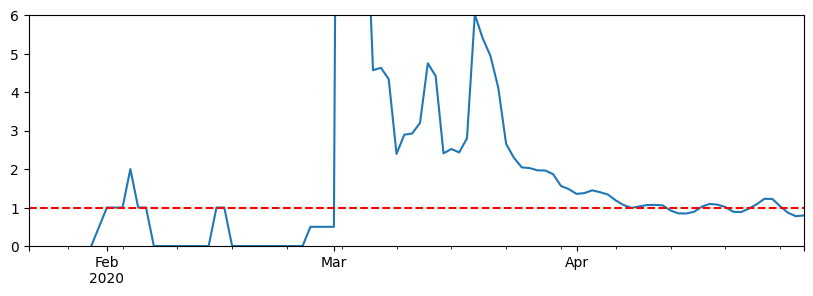

In [28]:
ax = df[df.index<"2020-05-01"]['Rt'].replace(np.inf,np.nan).fillna(method='pad').plot(figsize=(10,3))
ax.set_ylim([0,6])
ax.axhline(1,linestyle='--',color='red')
plt.show()

Another interesting indicator of the pandemic is the **derivative**, or **daily difference** in new cases. It allows us to see clearly when pandemic is increasing or declining. 

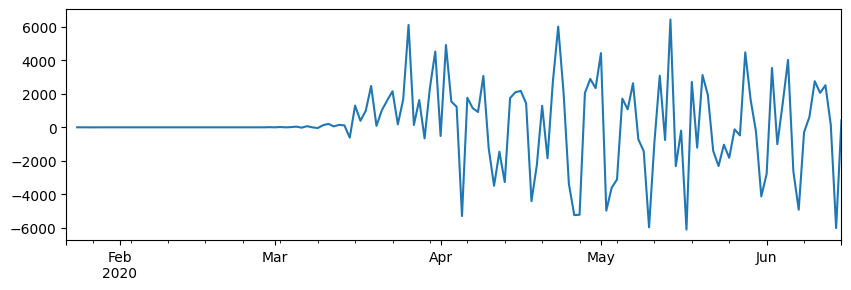

In [29]:
df['ninfected'].diff().plot()
plt.show()

Given the fact that there are a lot of fluctuations in data caused by reporting, it makes sense to smooth the curve by running rolling average to get the overall picture. Let's again focus on the first months of the pandemic:

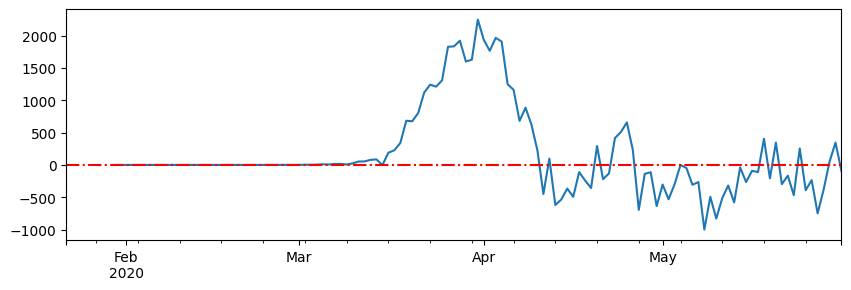

In [30]:
ax=df[df.index<"2020-06-01"]['ninfected'].diff().rolling(7).mean().plot()
ax.axhline(0,linestyle='-.',color='red')
plt.show()


## Challenge

Now it is time for you to play more with the code and data! Here are a few suggestions you can experiment with:
* See the spread of the pandemic in different countries.
* Plot $R_t$ graphs for several countries on one plot for comparison, or make several plots side-by-side
* See how the number of deaths and recoveries correlate with number of infected cases.
* Try to find out how long a typical disease lasts by visually correlating infection rate and deaths rate and looking for some anomalies. You may need to look at different countries to find that out.
* Calculate the fatality rate and how it changes over time. You may want to take into account the length of the disease in days to shift one time series before doing calculations

## References

You may look at further studies of COVID epidemic spread in the following publications:
* [Sliding SIR Model for Rt Estimation during COVID Pandemic](https://soshnikov.com/science/sliding-sir-model-for-rt-estimation/), blog post by [Dmitry Soshnikov](http://soshnikov.com)
* T.Petrova, D.Soshnikov, A.Grunin. [Estimation of Time-Dependent Reproduction Number for Global COVID-19 Outbreak](https://www.preprints.org/manuscript/202006.0289/v1). *Preprints* **2020**, 2020060289 (doi: 10.20944/preprints202006.0289.v1)
* [Code for the above paper on GitHub](https://github.com/shwars/SlidingSIR)